# Softmax Regression Implementation with PyTorch

In [1]:
import pandas as pd
import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = load_iris(as_frame=True)['frame']
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [3]:
# prepare X (features) and y (target)
X = df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)']]
y = df['target']

# do train_test_split (train:75, test:25)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [4]:
# determine whether system supports CUDA or not 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# convert numpy arrays into pytorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32, device=DEVICE)
X_test = torch.tensor(X_test.values, dtype=torch.float32, device=DEVICE)
y_train = torch.tensor(y_train.values, dtype=torch.float32, device=DEVICE)
y_test = torch.tensor(y_test.values, dtype=torch.float32, device=DEVICE)

## Implemention Softmax Regression

In [14]:
cost = []

class SoftmaxRegression(torch.nn.Module):
    
    def __init__(self, num_features, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)
        self.linear.weight.detach().zero_() # underscore at zero_() means operations is in-place
        self.linear.weight.detach().zero_()
        
    def forward(self, x):
        logits = self.linear(x)
        probas = torch.softmax(logits, dim=1)
        return logits, probas
    
    def evaluate(self, x, y):
        logits, probas = self.forward(x)
        y_pred = torch.argmax(probas, dim=1)
        accuracy = torch.sum(y_pred == y) / y.size(0)
        return accuracy
    
    ### Training ### 
    def train(self, x, y, num_epochs, learning_rate=0.01, minibatch_size=10, seed=123):
        
        torch.manual_seed(seed)
        
        # use gradient descent as the optimizer
        optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)
        
        for e in range(num_epochs):
            
            # creat minibatches             
            shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
            minibatches = torch.split(shuffle_idx, minibatch_size)
            
            for minibatch_idx in minibatches:
            
                # comp. outputs ###
                logits, probas = self.forward(x[minibatch_idx])
                
                # comp. the loss
                loss = F.cross_entropy(logits, y[minibatch_idx].long())
                
                # reset gradients from the previous interaction
                optimizer.zero_grad()
                
                # comp. gradients
                loss.backward()
                
                # update weights and bias
                optimizer.step()

            #### Logging ####      
            logits, probas = model(x)
            curr_loss = F.cross_entropy(logits, y.long())
            accuracy = self.evaluate(x, y)
            print('Epoch: %03d' % (e + 1), end="")
            print(' | Train Accuracy: %.3f' % accuracy, end="")
            print(' | Loss: %.3f' % curr_loss)
            cost.append(curr_loss)
        
        # print out weights and bias after training
        print(f'\n - Weight: {model.linear.weight}')
        print(f'- Bias: {model.linear.bias}')

In [15]:
# training
model = SoftmaxRegression(4, 3)
model.to(DEVICE)
model.train(X_train, y_train, num_epochs=130)

Epoch: 001 | Train Accuracy: 0.348 | Loss: 1.020
Epoch: 002 | Train Accuracy: 0.670 | Loss: 0.938
Epoch: 003 | Train Accuracy: 0.616 | Loss: 0.925
Epoch: 004 | Train Accuracy: 0.696 | Loss: 0.843
Epoch: 005 | Train Accuracy: 0.777 | Loss: 0.801
Epoch: 006 | Train Accuracy: 0.670 | Loss: 0.788
Epoch: 007 | Train Accuracy: 0.670 | Loss: 0.771
Epoch: 008 | Train Accuracy: 0.670 | Loss: 0.725
Epoch: 009 | Train Accuracy: 0.670 | Loss: 0.740
Epoch: 010 | Train Accuracy: 0.688 | Loss: 0.664
Epoch: 011 | Train Accuracy: 0.688 | Loss: 0.664
Epoch: 012 | Train Accuracy: 0.982 | Loss: 0.635
Epoch: 013 | Train Accuracy: 0.714 | Loss: 0.632
Epoch: 014 | Train Accuracy: 0.670 | Loss: 0.606
Epoch: 015 | Train Accuracy: 0.866 | Loss: 0.603
Epoch: 016 | Train Accuracy: 0.670 | Loss: 0.597
Epoch: 017 | Train Accuracy: 0.670 | Loss: 0.577
Epoch: 018 | Train Accuracy: 0.670 | Loss: 0.577
Epoch: 019 | Train Accuracy: 0.679 | Loss: 0.559
Epoch: 020 | Train Accuracy: 0.670 | Loss: 0.575
Epoch: 021 | Train A

## Model evaluation

In [16]:
# evaluate model on the test set
model.evaluate(X_test, y_test)

tensor(0.9737)

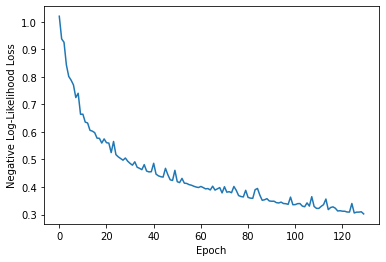

In [17]:
# plot the loss after each epoch
plt.plot(range(len(cost)), cost)
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood Loss')
plt.show()

- Using **minibatch mode** tends to be **noisier**